# TVB-testing

We will simply run a easy job for tvb-europa for testing. The main job is to do some signal simulation based on connectivity data. The first step is to import all the packages we used in this script.

In [1]:
import os
from tvb.simulator.lab import *
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

   INFO  log level set to INFO


/home/yxw190015/TVB_Distribution/tvb_data/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Downloading data
The sample data is from the github repo. We will download it and get the path for further using in simulation steps.

In [2]:
# download the data set and get the path
! wget -c -O connectivity_66.zip --no-check-certificate https://raw.githubusercontent.com/utdsimmons/tvb/main/testing_data/connectivity_66.zip
path = os.path.abspath("connectivity_66.zip")
print(path)

wget: /home/yxw190015/TVB_Distribution/tvb_data/lib/libuuid.so.1: no version information available (required by wget)
--2021-01-11 18:09:12--  https://raw.githubusercontent.com/utdsimmons/tvb/main/testing_data/connectivity_66.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

/home/yxw190015/TVB_Distribution/demo_scripts/connectivity_66.zip


## Simulation
The chunk below shows the parameters we should set up in our model. ANd then we can run the simulation.

In [3]:
# The main simulation parameters
sim = simulator.Simulator(
    model=ReducedSetHindmarshRose(), 
    connectivity=connectivity.Connectivity.from_file(path),                      
    coupling=coupling.Linear(a=np.array([0.02])),
    simulation_length=1e3,
    integrator=integrators.HeunStochastic(dt=0.01220703125, noise=noise.Additive(nsig=np.array([0.00001]), ntau=0.0,
                                                                                random_stream=np.random.RandomState(seed=42))),
    monitors=(
       monitors.TemporalAverage(period=1.),
       monitors.Raw(),
       monitors.ProgressLogger(period=1e2)
    )
).configure()
# Run the simulation
(tavg_time, tavg_data), (raw_time, raw_data),_ = sim.run()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
   INFO  step 1 time 0.0000 s
   INFO  step 8193 time 0.1000 s
   INFO  step 16385 time 0.2000 s
   INFO  step 24577 time 0.3000 s
   INFO  step 32769 time 0.4000 s
   INFO  step 40961 time 0.5000 s
   INFO  step 49153 time 0.6000 s
   INFO  step 57345 time 0.7000 s
   INFO  step 65537 time 0.8000 s
   INFO  step 73729 time 0.9000 s


## Visualization

Then we can have our brain signals results and visualize it. 

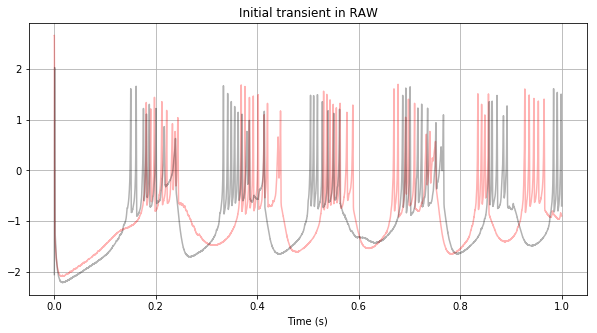

In [4]:
# results visualization
figure(figsize=(10, 5))
plt.plot(raw_time * 1e-3, raw_data[:, 0, 4, 0], "r", alpha=0.3)
plt.plot(raw_time * 1e-3, raw_data[:, 0, 5, 0], "k", alpha=0.3)
plt.title('Initial transient in RAW')
plt.xlabel('Time (s)')
plt.grid(True);

## Branching

Based on the previous results, another thing we need to test is the simulation branching. It is a process designed for continuous long time simulation. We will use a pickle to store and load the previous simulation state, then pass it to the next simulation.

In [5]:
# using pickle to do the branching
sim_state_fname = 'sim_state.pickle'

with open(sim_state_fname, 'wb') as file_descr:
    cPickle.dump({
        'history': sim.history.buffer,
        'current_step': sim.current_step,
        'current_state': sim.current_state,
        'rng': sim.integrator.noise.random_stream.get_state()
    }, file_descr)
    
# detecting pickle file
!ls -lh sim_state.pickle

# clear the previous simulation
del sim

-rw-r--r-- 1 yxw190015 tvb 31M Jan 11 18:10 sim_state.pickle


## Simulation again

Then we can do braching simulation. We will need to set up all the parameters again and load the previous simulation states.

In [6]:
# setting parameters again
sim = simulator.Simulator(
    model=ReducedSetHindmarshRose(), 
    connectivity=connectivity.Connectivity.from_file(path),                      
    coupling=coupling.Linear(a=np.array([0.02])),
    simulation_length=1e3,
    integrator=integrators.HeunStochastic(dt=0.01220703125, noise=noise.Additive(nsig=np.array([0.00001]), ntau=0.0,
                                                                                random_stream=np.random.RandomState(seed=42))),
    monitors=(
       monitors.TemporalAverage(period=1.),
       monitors.Raw(),
       monitors.ProgressLogger(period=1e2)
    )
).configure()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [7]:
# loading the previous states
with open(sim_state_fname, 'rb') as file_descr:
    state = cPickle.load(file_descr)

sim.history.buffer = state['history']
sim.current_step = state['current_step']
sim.current_state = state['current_state']
sim.integrator.noise.random_stream.set_state(state['rng'])
# run simulation again
(tavg_time, tavg_data), (raw_time, raw_data),_ = sim.run()

   INFO  step 81921 time 1.0000 s
   INFO  step 90113 time 1.1000 s
   INFO  step 98305 time 1.2000 s
   INFO  step 106497 time 1.3000 s
   INFO  step 114689 time 1.4000 s
   INFO  step 122881 time 1.5000 s
   INFO  step 131073 time 1.6000 s
   INFO  step 139265 time 1.7000 s
   INFO  step 147457 time 1.8000 s
   INFO  step 155649 time 1.9000 s


## Visualization

The last, we can visualize the simulation results. 

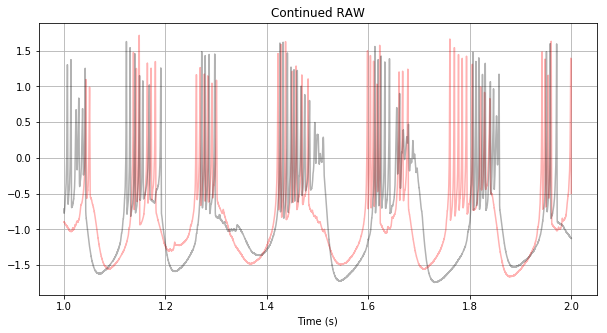

In [8]:
# visualize the results
figure(figsize=(10, 5))
plt.plot(raw_time * 1e-3, raw_data[:, 0, 4, 0], "r", alpha=0.3)
plt.plot(raw_time * 1e-3, raw_data[:, 0, 5, 0], "k", alpha=0.3)
plt.title('Continued RAW')
plt.xlabel('Time (s)')
plt.grid(True);